# Customer Segmentation Report
Customer segmentation is a way to identify groups of similar customers. Customers can be segmented on a wide variety of characteristics, such as demographic information, purchase behavior, and attitudes. In this notebook I will process and segment customer purchase data using a K-means clustering algorithm. It also includes a snake plot and heatmap to visualize the resulting clusters and feature importance.

The dataset in this notebook consists of customer data, including purchase recency, frequency, and monetary value. Each row represents a different customer with a distinct customer ID.

## 1. Loading packages and Inspecting the Data
The code below imports the packages necessary for data manipulation, visualization, pre-processing, and clustering. It also sets up the visualization style and loads in the data.

Finally, it inspects the data types and missing values with the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method from `pandas`.

In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set visualization style
sns.set_style("darkgrid")

# Load the data and replace with your CSV file path
df = pd.read_csv("data/customer_data.csv")

# Preview the data
df

,CustomerID,Recency,Frequency,MonetaryValue
0,12747,3,25,948.70
1,12748,1,888,7046.16
2,12749,4,37,813.45
3,12820,4,17,268.02
4,12822,71,9,146.15
...,...,...,...,...
3638,18280,278,2,38.70
3639,18281,181,2,31.80
3640,18282,8,2,30.70
3641,18283,4,152,432.93


In [2]:
# Check columns for data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3643 entries, 0 to 3642
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3643 non-null   int64  
 1   Recency        3643 non-null   int64  
 2   Frequency      3643 non-null   int64  
 3   MonetaryValue  3643 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 114.0 KB


## 2. Exploring the Data
CustomerID is omitted because it is an identifier and not useful for clustering.

The code below reduces the DataFrame to the columns I want to cluster on and then print descriptive statistics using the [`describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) method from `pandas`.

Printing descriptive statistics is helpful because K-means clustering has several key assumptions that can be revealed via this exploration:
1. There is no skewness to the data.
2. The variables have the same average values.
3. The variables have the same variance.

In [3]:
# Select columns for clustering
columns_for_clustering = ["Recency", "Frequency", "MonetaryValue"]

# Create new DataFrame with clustering variables
df_features = df[columns_for_clustering]

# Print a summary of descriptive statistics
df_features.describe()

,Recency,Frequency,MonetaryValue
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


The [`facetgrid()`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) function from `seaborn` creates a grid of histograms of the data to be clustered.  It serves as a further exploration of the data to determine its skew and whether it needs transformation.

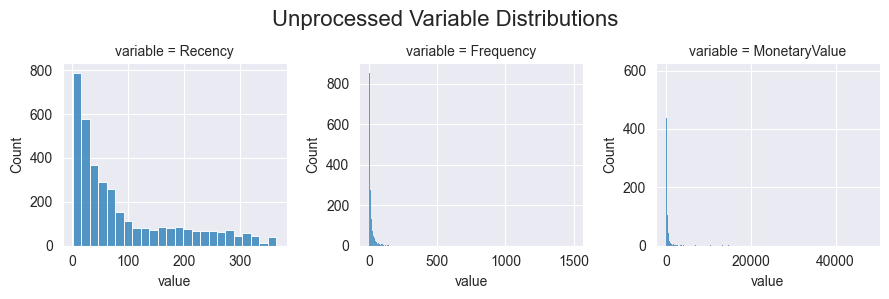

In [4]:
# Plot the distributions of the selected variables
g = sns.FacetGrid(
    df_features.melt(),  # Reformat the DataFrame for plotting purposes
    col="variable",  # Split on the 'variable' column created by reformating
    sharey=False,  # Turn off shared y-axis
    sharex=False,  # Turn off shared x-axis
)
# Apply a histogram to the facet grid
g.map(sns.histplot, "value")
# Adjust the top of the plots to make room for the title
g.fig.subplots_adjust(top=0.8)
# Create a title
g.fig.suptitle("Unprocessed Variable Distributions", fontsize=16)
plt.show()

Before proceeding, it is crucial to ensure that all columns selected for clustering are numeric. 

In [5]:
all([pd.api.types.is_numeric_dtype(df_features[col]) for col in columns_for_clustering])

True

## 3. Pre-processing the Data
Based on the grids above, there are skews, I have to remove the skew and center the variables.
- First, a log transformation is applied to the data using the `numpy` [`log()`](https://numpy.org/doc/stable/reference/generated/numpy.log.html) function. A log transformation unskews the data in preparation for clustering.
- Next, the `StandardScaler()` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) fits and transforms the log-transformed data. This centers and scales the data in further preparation for clustering.
- Finally, a new DataFrame is created and visualized again to confirm the results.

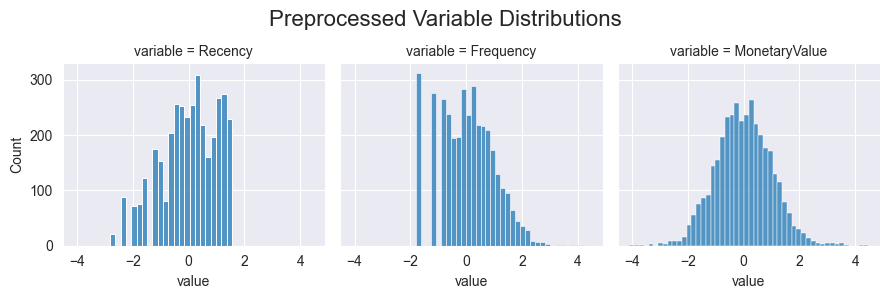

In [6]:
# Perform a log transformation of the data to unskew the data
df_log = np.log(df_features)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(df_log)

# Scale and center the data
df_normalized = scaler.transform(df_log)

# Create a pandas DataFrame of the processed data
df_processed = pd.DataFrame(
    data=df_normalized, index=df_features.index, columns=df_features.columns
)

# Plot the distributions of the selected variables
g = sns.FacetGrid(df_processed.melt(), col="variable")
g.map(sns.histplot, "value")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Preprocessed Variable Distributions", fontsize=16)
plt.show()

## 4. Choosing the Number of Clusters

The next step is to fit a variable number of clusters and plot each cluster's sum-of-squared errors (SSE). The SSE reflects the sum of squared distances from every data point to the cluster center. The aim is to reduce the SSE while still maintaining a reasonable number of clusters. 

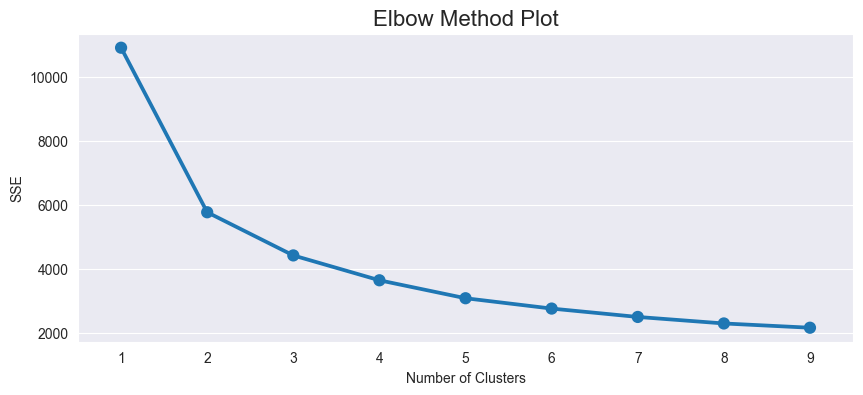

In [7]:
# Set the maximum number of clusters to plot
max_clusters = 10

# Initialize empty dictionary to store sum of squared errors
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, max_clusters):
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    # Fit KMeans on the normalized dataset
    kmeans.fit(df_processed)
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Initialize a figure of set size
plt.figure(figsize=(10, 4))

# Create an elbow plot of SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

# Add labels to the plot
plt.title("Elbow Method Plot", fontsize=16)  # Add a title to the plot
plt.xlabel("Number of Clusters")  # Add x-axis label
plt.ylabel("SSE")  # Add y-axis label

# Show the plot
plt.show()

## 5. Clustering the Data
I can now select an optimal number of clusters based on the elbow plot above by setting `k`. In this example, `k` is set to 3.

[`KMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from `sklearn.cluster` with `k` clusters is then fit to the processed data, and the cluster labels are extracted and assigned back to the original data. 

In [8]:
# Choose number of clusters
k = 3

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(df_processed)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a new DataFrame by adding a new cluster column to the original data
df_clustered = df.assign(Cluster=cluster_labels)

# Preview the clustered DataFrame
df_clustered

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12747,3,25,948.70,0
1,12748,1,888,7046.16,0
2,12749,4,37,813.45,0
3,12820,4,17,268.02,0
4,12822,71,9,146.15,2
...,...,...,...,...,...
3638,18280,278,2,38.70,1
3639,18281,181,2,31.80,1
3640,18282,8,2,30.70,1
3641,18283,4,152,432.93,0


## 6. Inspecting the Clusters
### 6a. Visualizing the Raw Values by Cluster
The next step is to analyze the unprocessed data by cluster. The `pandas` method [`DataFrame.groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html), combined with the [`.size()`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.size.html) method, returns the total number of rows per `Cluster`.

In [9]:
# Group the data by cluster and calculate the total number of rows per group
df_sizes = df_clustered.groupby(["Cluster"], as_index=False).size()

# Inspect the row counts
df_sizes

,Cluster,size
0,0,901
1,1,1156
2,2,1586


Next, the mean values per cluster are visualized. The data is grouped again, and this time, the `pandas` method [`.mean()`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html) is used to aggregate the data by cluster and calculate the mean for each variable. Alternatively, the [`.agg()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html) method can also be used to specify specific aggregations for different columns if necessary.


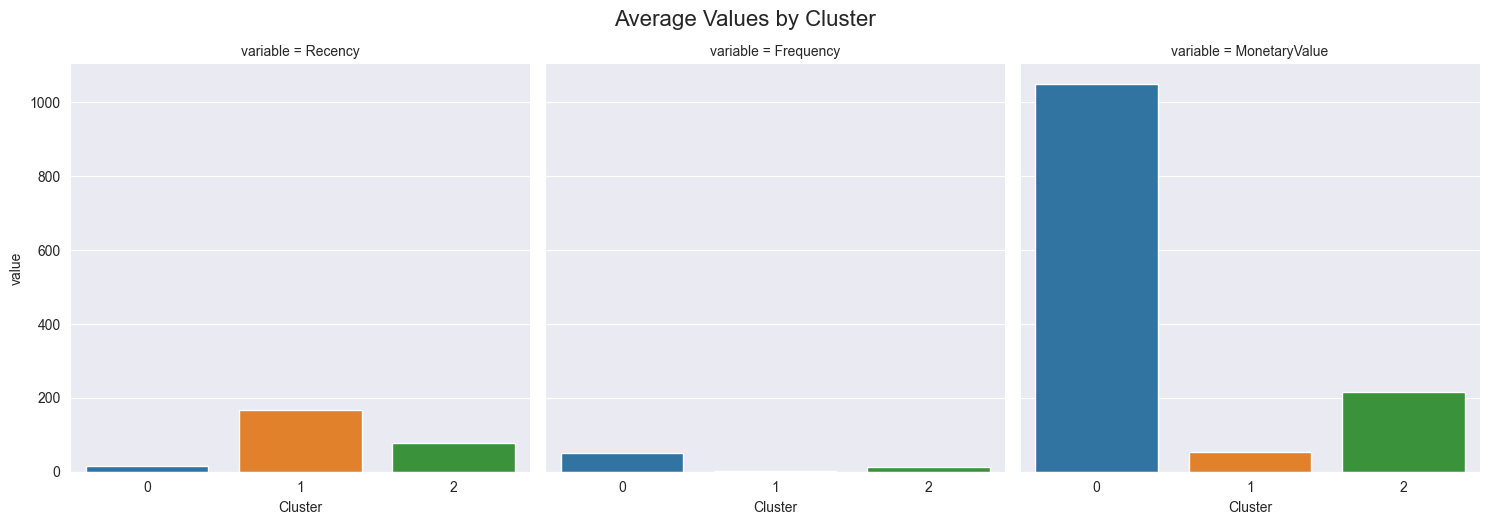

In [10]:
# Calculate the mean of feature columns by cluster
df_means = df_clustered.groupby(["Cluster"])[df_features.columns].mean().reset_index()

# Plot the distributions of the selected variables
sns.catplot(
    data=df_means.melt(id_vars="Cluster"),  # Transform the data to enable plotting
    col="variable",
    x="Cluster",
    y="value",
    kind="bar",
)

# Add a title
plt.suptitle("Average Values by Cluster", y=1.04, fontsize=16)

# Show the plot
plt.show()

### 6b. Create a Snake Plot of the Clusters
The next step takes the processed data and visualizes the differences between the clusters using a snake plot. This can be helpful spot trends or key differences that would not be visible with the raw data. The code below uses the following code:
- [`DataFrame.assign()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html) adds the cluster labels to the processed data.
- [`DataFrame.melt()`](https://pandas.pydata.org/pandas-docs/version/1.0.0/reference/api/pandas.DataFrame.melt.html) transforms the data from wide to long format, which makes plotting easier.
- Finally, the `seaborn` [`lineplot()`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) function is used to plot three lines, one for each cluster.

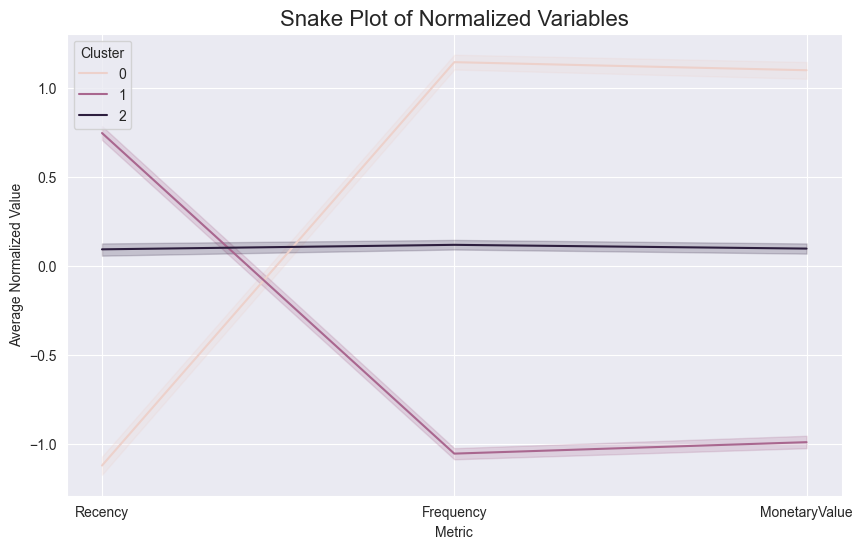

In [11]:
# Assign cluster labels to processed DataFrame
df_processed_clustered = df_processed.assign(Cluster=cluster_labels)

# Melt the normalized DataFrame and reset the index
df_processed_melt = pd.melt(
    df_processed_clustered.reset_index(),
    # Assign the cluster labelss as the ID
    id_vars=['Cluster'],
    # Assign clustering variables as values
    value_vars=df_features.columns,
    # Name the variable and value
    var_name="Metric",
    value_name="Value",
)

# Change the figure size
plt.figure(figsize=(10, 6))

# Add label and titles to the plot
plt.title('Snake Plot of Normalized Variables', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Average Normalized Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=df_processed_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

### 6c. Create a Heatmap of Relative Importances
Another technique to help visualize how each segment is distinct is to plot the relative importance. The code below achieves this by doing the following:
- First, it calculates the average values for each cluster.
- Next, it calculates the average values for the total population.
- It then divides the cluster averages by the population averages and subtracts one.

This provides a relative importance score for each of the different features used for clustering. The `seaborn` [`heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function plots these relative importances on a red to blue color scale to help visualize the relative importance of each attribute to the segments.

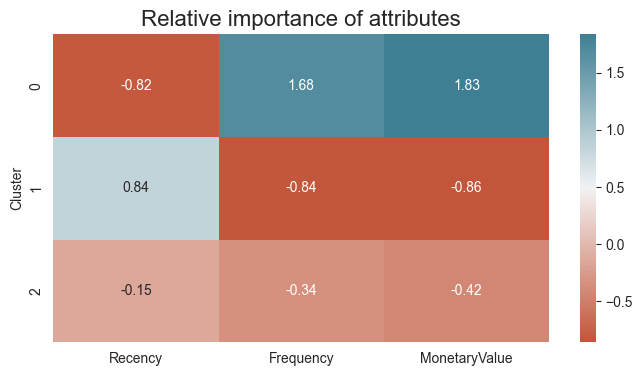

In [12]:
# Calculate average RFM values for each cluster
cluster_avg = df_clustered.groupby(["Cluster"])[columns_for_clustering].mean()

# Calculate average RFM values for the total customer population
population_avg = df[columns_for_clustering].mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Change the figure size
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title("Relative importance of attributes", fontsize=16)

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt=".2f", cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.show()